In [2]:
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.stats import lognorm
from scipy.spatial import cKDTree


### This script contains the procedure used for Impact calculation in TV0 using following steps:
1. Importing data
2. Defining building fragility functions
3. Calculating physical impact
5. Comparison of HA and CW results

# 1. Importing data

In [20]:
#Loading all the recording locations in the TV_domain
locf_dir='C:/Users/s2122917/Documents/CUBIT_SPEED/GMS_basin/Karim_work/allRuptureModels_LS/3_LS_TomoFigs/3_LS_TomoFigs/'
df_locations = pd.read_csv(locf_dir+"LS.input", skiprows=1, names=["nodeID", "x", "y", "z"], delim_whitespace=True)

In [3]:
###Loading Aj and building info
ajdir='C:/Users/s2122917/Documents/Risk_work/TV0_results_chenbo/files_for_Himanshu/files_for_Himanshu/'
df_aj_build=geopandas.read_file(ajdir+'bldPort_TV0_aj3.shp')
df_aj_fac=geopandas.read_file(ajdir+'blg_Fac_TV0_aj3.shp')

In [4]:
##Loading PGA based building index
riskdir='C:/Users/s2122917/Documents/Risk_work/TV0_results_chenbo/'
pgabuild=pd.read_csv(riskdir+'idx_PGA_based_buildings.csv',names=['idx']) 
df_building_pga=df_aj_build[pgabuild['idx']==1]
df_building_pga=df_building_pga.reset_index()

In [5]:
## Loading PGA values for all earthquake scenarios
pgadir='C:/Users/s2122917/Documents/Risk_work/TV0_GM/'
df_pga_build=geopandas.read_file(pgadir+'bldPort_TV0_pga.shp')
df_pga_build_pga=df_pga_build[pgabuild['idx']==1]
df_pga_build_pga=df_pga_build_pga.reset_index()

In [77]:
#loading polygons
tv0_dir='C:/Users/s2122917/Documents/Risk_work/TV0_layout/'
polygons=tv0_dir+'polygonsTV0.shp'
df_polygons=geopandas.read_file(polygons)
df_poly_lowinc=df_polygons[df_polygons['type']=='lowIncome']
df_poly_midinc=df_polygons[df_polygons['type']=='midIncome']
df_poly_highinc=df_polygons[df_polygons['type']=='highIncome']

## 2. Defining building fragility functions

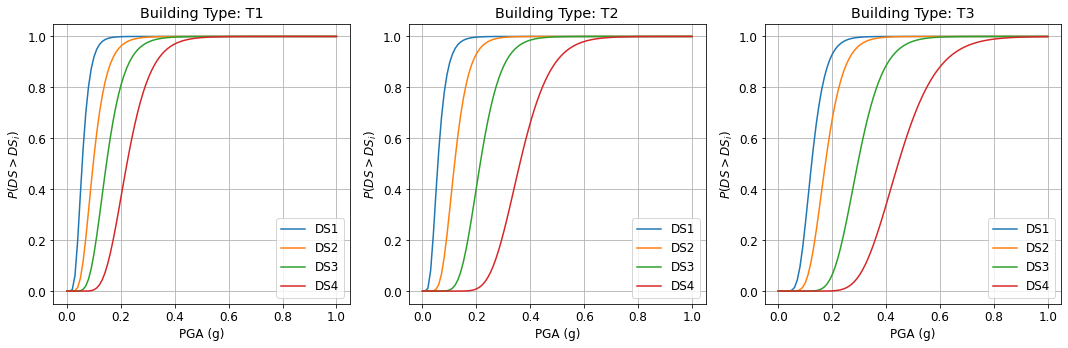

In [15]:

# Ground motion intensity levels
pga_levels = np.linspace(0, 1, 100)
plt.rc('font',size=12)

# Median and dispersion values for the 4 damage states for each building type
building_types = {
    "T1": {
         "medians": [0.057, 0.098, 0.147, 0.223],
        "dispersions": [0.406, 0.404, 0.358, 0.310]
    },
    "T2": {
       
        "medians": [0.057, 0.119, 0.214, 0.361],
        "dispersions": [0.451, 0.349, 0.286, 0.247]
    },
    "T3": {
        "medians": [0.124, 0.175, 0.295, 0.445],
        "dispersions": [0.326, 0.300, 0.254, 0.254]
       
    }
}

# Create subplots for each building type
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Labels for the damage states
damage_state_labels = ["DS1", "DS2", "DS3", "DS4"]

for i, (building_type, data) in enumerate(building_types.items()):
    ax = axes[i]
    medians = data["medians"]
    dispersions = data["dispersions"]
    
    ax.set_title(f'Building Type: {building_type}')
    
    for median, dispersion, ds_label in zip(medians, dispersions, damage_state_labels):
        exceedance_probability = lognorm.cdf(pga_levels, s=dispersion, scale=(median))
        ax.plot(pga_levels, exceedance_probability, label=f'{ds_label}')
    
    ax.set_xlabel('PGA (g)')
    ax.set_ylabel('$P(DS>DS_i)$')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Calculate physical impact 


Steps:<br>
a. Find pga values corresponding to the building (PGA bvased typology) locations <br>
b. Calculating the $IA_i$
$\overline{(DS)}_{w,i} = P_{DS=1} ×1 + P_{DS=2} ×2 + P_{DS=3} ×3+ P_{DS=4} ×4 \newline$ 
$IA_i = \frac{\overline{(DS)}_{w,i}}{\overline{(DS)}_{w,max}}$ <br>
c. Plot the damage $IA_i$ versus $lnA_j$

#### a.  Find PGA values corresponding to the building (PGA based typology) locations

In [21]:
df_locations_tv=df_locations[:10000]
# Create a cKDTree for locations_coords
locations_coords = df_locations_tv[['x', 'y']]
locations_tree = cKDTree(locations_coords)

# Create a list of tuples for the coordinates in df_building_pga
building_pga_coords = list(zip(df_building_pga['xcoord'], df_building_pga['ycoord']))

# Find the closest points in locations_coords for each point in building_pga_coords
closest_points_indices = locations_tree.query(building_pga_coords,k=1)[1]

# Now, closest_points_indices contains the index values in df_locations_tv of the closest points to each point in df_building_pga
print(closest_points_indices)


[4789 3890 3890 ... 6529 6627 6529]


#### b. Calculating the $IA_i$ 
- Extract the fragility functions from building dataset and calculate the probablity according to the pga values from scenario earthquakes (EQ 2,4,13,15 and 22).<br>
- Calculate the average weighted damage state.<br>
- Calculating the IAi by normalising with the maximum values across all the buildings.

In [92]:
DSwi=[]
eq=[2,4,13,15,22] # Test earthquake in when Earthquakes are numbered from 1 to 23

for build in df_building_pga.index.values:
    
######### obtaining fragility function corresponding to the building index, i.e. the median and dispersion
    if df_building_pga.iloc[build]['vulnStrEQ']=='BrM+LC+LR':
        tb='T1'
    elif df_building_pga.iloc[build]['vulnStrEQ']=='BrCfl+LC+LR':
        tb='T2' 
    elif df_building_pga.iloc[build]['vulnStrEQ']=='BrCri+LC+LR':
        tb='T3' 
     
    medians = building_types[tb]['medians']
    dispersions = building_types[tb]['dispersions']

######### Extracting pga values for buildings for test earthquake scnearios 
    pga_values=[]
    for eqi in eq:
        pga_values.append(df_pga_build_pga['pga_sim'+str(eqi)][build]/9.81)
######### Calculating the probabilities according to the pga values
   
    exceedance_probabilities = []
    for pga in pga_values:
        exceedences=np.array([lognorm.cdf(pga, s=dispersion, scale=median) for median, dispersion in zip(medians, dispersions)])
        
        exact=[exceedences[0]-exceedences[1],exceedences[1]-exceedences[2],exceedences[2]-exceedences[3],exceedences[3]]
        exceedance_probabilities.append(exact)
        
######### Calculate weighted probabilities for each damage state
    weighted_probabilities = []
    for exceedances in exceedance_probabilities:
        weighted_probabilities.append([exceedance * weight for exceedance, weight in zip(exceedances, [1, 2, 3, 4])])

    DSwi.append(np.sum(weighted_probabilities,axis=1))
    
    
    
DSwi=np.array(DSwi)

## Calculating the IAi by normalising with the maximum values across all the buildings
ia_eq=np.mean(DSwi,axis=1)/np.max(np.mean(DSwi,axis=1))


In [91]:
DSwi.shape

(2441, 5, 4)

#### c. Plotting the $IA_i$ versus $lnA_j$

Text(0, 0.5, '$IA_i$')

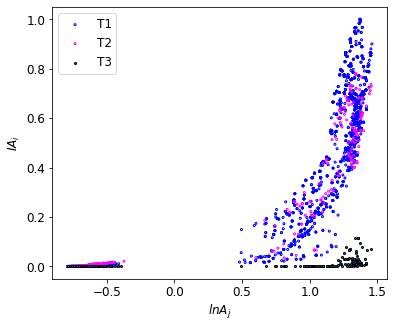

In [23]:
plt.figure(figsize=(6,5))
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrM+LC+LR'],ia_eq[df_building_pga['vulnStrEQ']=='BrM+LC+LR'],s=4,edgecolors='blue',facecolors='none',label='T1')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],ia_eq[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],s=4,edgecolors='magenta',facecolors='none',label='T2')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],ia_eq[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],s=4,edgecolors='black',marker='o',label='T3')
plt.legend()
plt.xlabel(r'$lnA_j$')
plt.ylabel(r'$IA_i$')


### CW (chenbo's) results

Text(0.5, 0, '$lnA_j$')

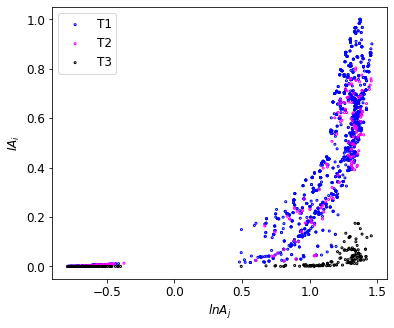

In [24]:
chenbo_ds=pd.read_csv(ajdir+'DS_avg_wa_all_vuln.csv',names=['ds'])
plt.figure(figsize=(6,5))

plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrM+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrM+LC+LR'],s=4,edgecolors='blue',facecolors='none',label='T1')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],s=4,edgecolors='magenta',facecolors='none',label='T2')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],s=4,edgecolors='black',facecolors='none',label='T3')
plt.legend()
plt.ylabel(r'$IA_i$')
plt.xlabel(r'$lnA_j$')


## 4. Comparison of HA values with CW values

Text(0, 0.5, 'Residual')

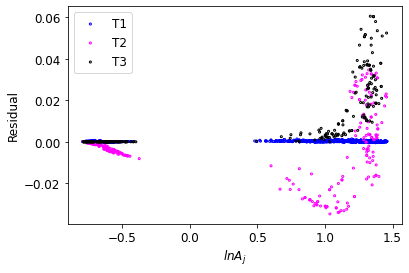

In [25]:
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrM+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrM+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrM+LC+LR'],s=4,edgecolors='blue',facecolors='none',label='T1')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCfl+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'],s=4,edgecolors='magenta',facecolors='none',label='T2')
plt.scatter(df_building_pga.aj[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCri+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'],s=4,edgecolors='black',facecolors='none',label='T3')
plt.xlabel(r'$lnA_j$')
plt.legend()
plt.ylabel('Residual')

### Plotting histogram of residuals

In [26]:
residual_T1=chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrM+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrM+LC+LR']
residual_T2=chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCfl+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR']
residual_T3=chenbo_ds.ds[:2441][df_building_pga['vulnStrEQ']=='BrCri+LC+LR']-ia_eq[df_building_pga['vulnStrEQ']=='BrCri+LC+LR']

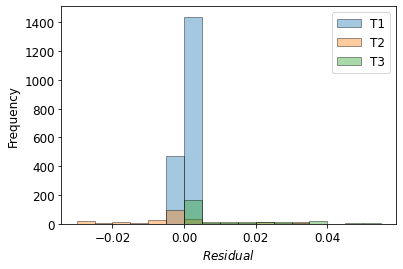

In [74]:
## All building typologies

bins=np.arange(-0.03,0.06,0.005)

plt.hist(residual_T1,bins=bins,edgecolor='black',alpha=0.4,label='T1')
plt.hist(residual_T2,bins=bins,edgecolor='black',alpha=0.4,label='T2')
plt.hist(residual_T3,bins=bins,edgecolor='black',alpha=0.4,label='T3')
plt.xlabel(r'$Residual$')
plt.ylabel('Frequency')
plt.legend()

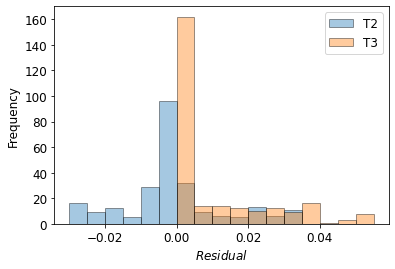

In [73]:
## Only T2 and T3

bins=np.arange(-0.03,0.06,0.005)
plt.hist(residual_T2,bins=bins,edgecolor='black',alpha=0.4,label='T2')
plt.hist(residual_T3,bins=bins,edgecolor='black',alpha=0.4,label='T3')
plt.xlabel(r'$Residual$')
plt.ylabel('Frequency')
plt.legend()

### Map of the residuals

**All building typologies**

<Axes: >

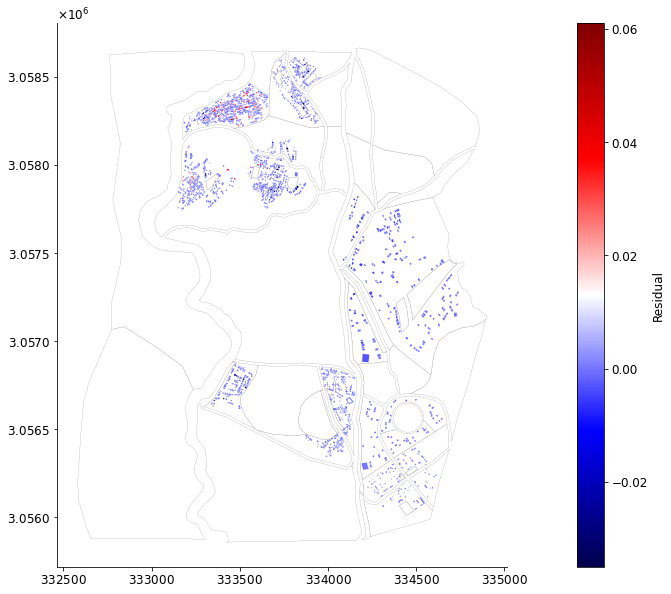

In [85]:
fig,ax=plt.subplots(figsize=(25,10))


residual=chenbo_ds.ds[:2441]-ia_eq
residual=np.round(residual,3)
df_building_pga['residual']=residual

df_polygons.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ticklabel_format(useMathText=True)

df_building_pga.plot(ax=ax,column='residual',cmap='seismic',legend='True',legend_kwds={"label": 'Residual'} )


**Plotting only T1**

<Axes: >

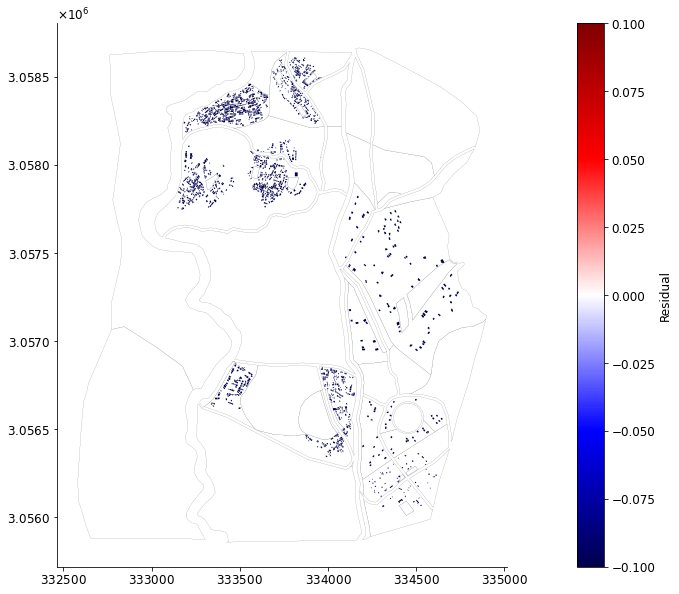

In [86]:
fig,ax=plt.subplots(figsize=(25,10))
df_polygons.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ticklabel_format(useMathText=True)

df_building_pga[df_building_pga['vulnStrEQ']=='BrM+LC+LR'].plot(ax=ax,column='residual',cmap='seismic',legend='True',legend_kwds={"label": 'Residual'})

**Plotting only T2**

<Axes: >

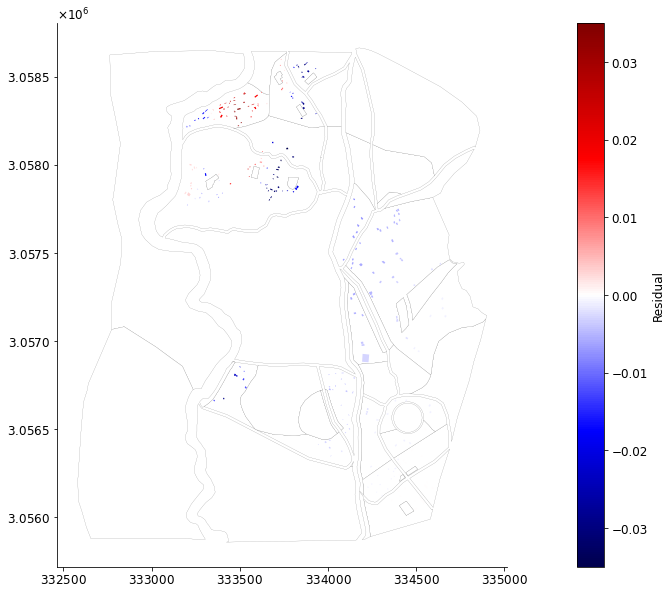

In [87]:
fig,ax=plt.subplots(figsize=(25,10))
df_polygons.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ticklabel_format(useMathText=True)

df_building_pga[df_building_pga['vulnStrEQ']=='BrCfl+LC+LR'].plot(ax=ax,column='residual',cmap='seismic',legend='True',legend_kwds={"label": 'Residual'})

**Plotting only T3**

<Axes: >

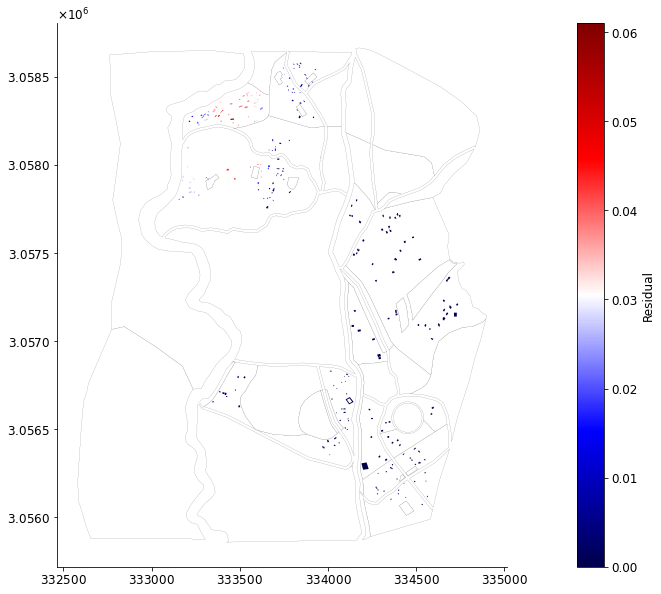

In [88]:
fig,ax=plt.subplots(figsize=(25,10))
df_polygons.plot(ax=ax,color='white',edgecolor='black',linewidth=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ticklabel_format(useMathText=True)

df_building_pga[df_building_pga['vulnStrEQ']=='BrCri+LC+LR'].plot(ax=ax,column='residual',cmap='seismic',legend='True',legend_kwds={"label": 'Residual'})